## Introduction

- Nous sommes Data Scientist dans une société financière nommmée "Prêt à dépenser". Cette dernière propose des crédits à la consommation (des prêts remboursés de façon échelonnée dans le temps) pour des personnes n'ayant pas ou peu d'historique de prêts.
- L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client (la probabilité qu'il ne rembourse pas) pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).
- L'entreprise veut aussi développer un dashboardd intéractif pour que les chargés clients puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

## Mission

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

## Spécifications du dashboard

- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

## Install

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Matt\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Matt\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Matt\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Matt\Anaconda3\python.exe -m pip install --upgrade pip' command.


## Import

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

C:\Users\Matt\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Datasets

In [6]:
app_train = pd.read_csv('./data/application_train.csv')
bureau = pd.read_csv('./data/bureau.csv')

## Data cleaning

#### application

In [7]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
app_train.shape

(307511, 122)

In [9]:
app_train.isna().mean().sort_values()

SK_ID_CURR                     0.000000
HOUR_APPR_PROCESS_START        0.000000
REG_REGION_NOT_WORK_REGION     0.000000
LIVE_REGION_NOT_WORK_REGION    0.000000
REG_CITY_NOT_LIVE_CITY         0.000000
                                 ...   
NONLIVINGAPARTMENTS_MEDI       0.694330
NONLIVINGAPARTMENTS_MODE       0.694330
COMMONAREA_MODE                0.698723
COMMONAREA_AVG                 0.698723
COMMONAREA_MEDI                0.698723
Length: 122, dtype: float64

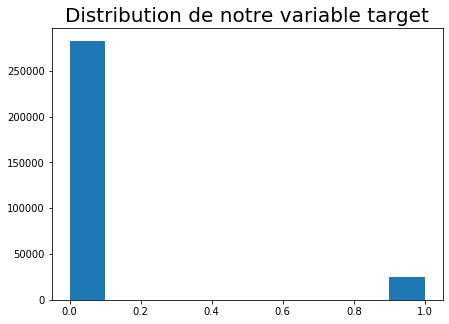

In [10]:
plt.figure(figsize=(7,5))
plt.hist(app_train['TARGET'])
plt.title('Distribution de notre variable target', fontsize = 20);

In [11]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

- Le 1 représente le nombre de paiement en retard (~8%)

#### bureau

In [12]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [13]:
bureau.shape

(1716428, 17)

In [14]:
bureau.isna().mean().sort_values()

SK_ID_CURR                0.000000
SK_ID_BUREAU              0.000000
CREDIT_ACTIVE             0.000000
CREDIT_CURRENCY           0.000000
DAYS_CREDIT               0.000000
CREDIT_DAY_OVERDUE        0.000000
DAYS_CREDIT_UPDATE        0.000000
CNT_CREDIT_PROLONG        0.000000
AMT_CREDIT_SUM_OVERDUE    0.000000
CREDIT_TYPE               0.000000
AMT_CREDIT_SUM            0.000008
DAYS_CREDIT_ENDDATE       0.061496
AMT_CREDIT_SUM_DEBT       0.150119
AMT_CREDIT_SUM_LIMIT      0.344774
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_MAX_OVERDUE    0.655133
AMT_ANNUITY               0.714735
dtype: float64

## Label encoding

In [15]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [16]:
app_train = pd.get_dummies(app_train)

## Valeurs abérrantes

In [17]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

- Ici la valeur max correspond à 1000 ans

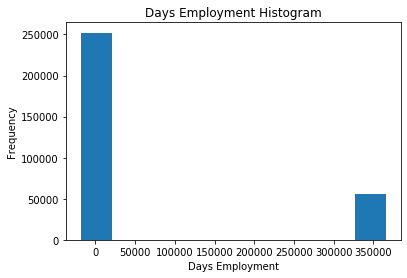

In [18]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [19]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


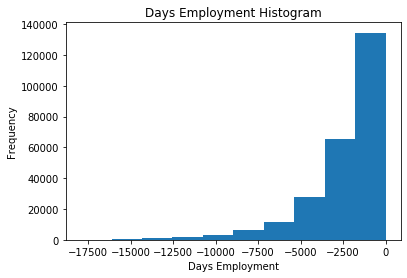

In [20]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [21]:
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [22]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830984513

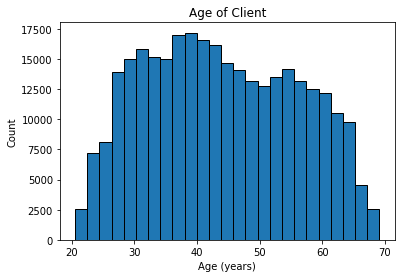

In [23]:
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

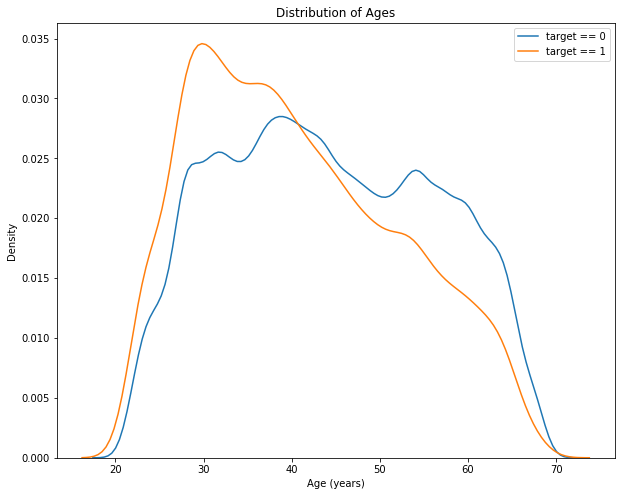

In [24]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [25]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [26]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


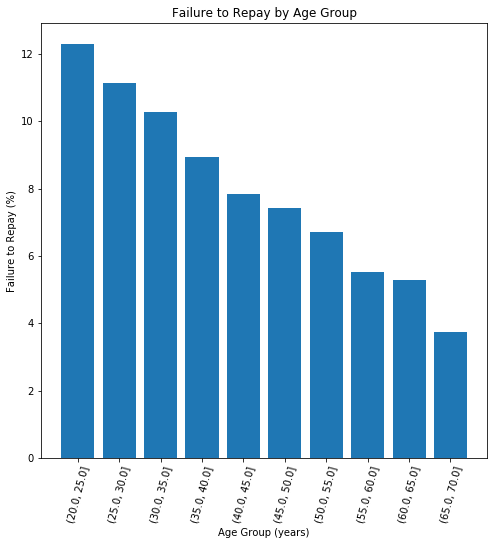

In [27]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [28]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


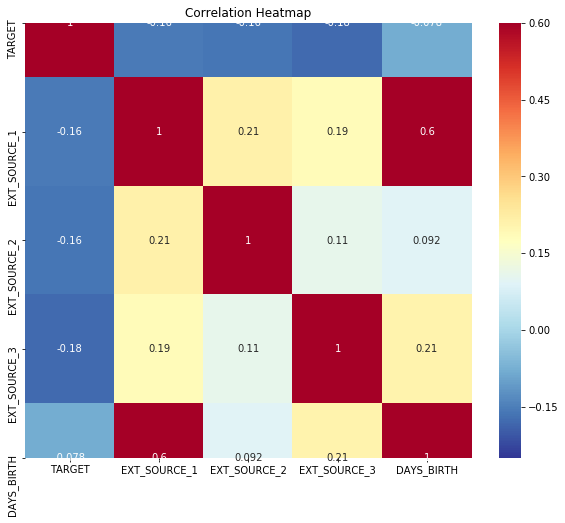

In [29]:
plt.figure(figsize = (10, 8))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

C:\Users\Matt\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Matt\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


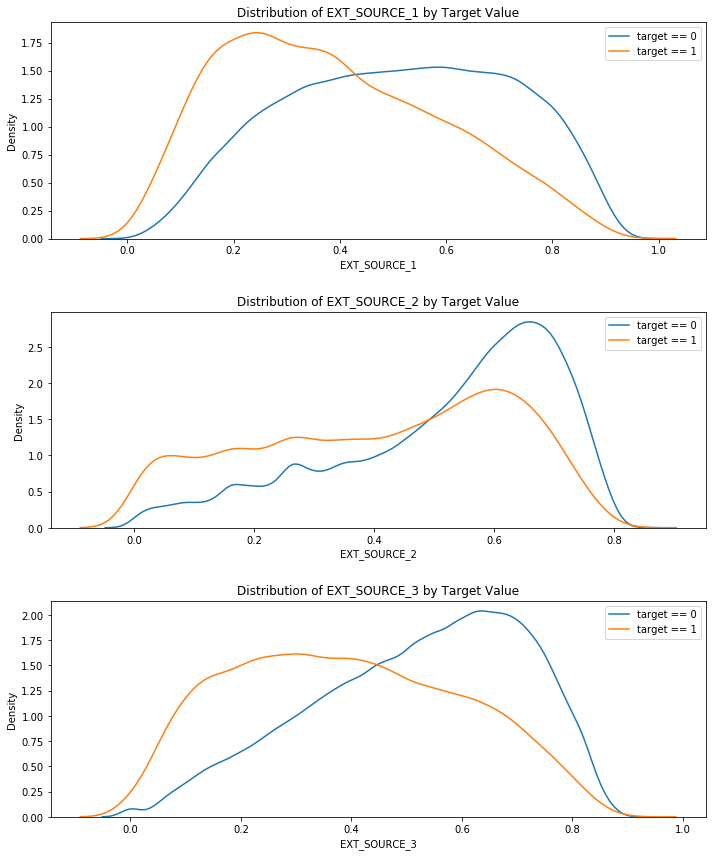

In [30]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [31]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [32]:
# Train the polynomial features
poly_transformer.fit(poly_features)
# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [33]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [34]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target
#sur tout le jeu de donnée.

In [35]:
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

In [36]:
app_train_poly

,SK_ID_CURR,TARGET_x,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET_y
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,1
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,0.248701,4333.535804,0.195302,3403.064320,5.929720e+07,0.153368,2672.378236,4.656525e+07,8.113830e+11,0
307507,456252,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,0.007202,279.510194,0.033234,1289.874083,5.006225e+07,0.153368,5952.466801,2.310256e+08,8.966503e+12,0
307508,456253,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,0.062812,4295.209004,0.025661,1754.727146,1.199916e+08,0.010483,716.860892,4.902031e+07,3.352102e+12,0
307509,456254,1,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,0.174750,3162.050698,0.224665,4065.229651,7.355897e+07,0.288836,5226.384299,9.456968e+07,1.711207e+12,1


In [37]:
list_col = app_train_poly.columns

In [38]:
app_train_poly = imputer.fit_transform(app_train_poly)

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [40]:
app_train_poly = pd.DataFrame(data= app_train_poly, columns=list_col)

In [41]:
# app_train_poly['credit_annuity_ratio'] = app_train_poly['AMT_CREDIT'] / app_train_poly['AMT_ANNUITY']
# app_train_poly['credit_goods_price_ratio'] = app_train_poly['AMT_CREDIT'] / app_train_poly['AMT_GOODS_PRICE']
# app_train_poly['credit_downpayment'] = app_train_poly['AMT_GOODS_PRICE'] - app_train_poly['AMT_CREDIT']
# app_train_poly = app_train_poly.dropna()

In [42]:
# datasettest = app_train_poly.loc[np.random.choice(app_train_poly.index, 10000, replace=False)] 

In [43]:
#datasettest = datasettest.set_index('SK_ID_CURR')

In [44]:
#datasettest.to_csv('fulldata.csv')

In [45]:
from sklearn.model_selection import train_test_split
X = app_train_poly.drop(['SK_ID_CURR', 'TARGET_x', 'TARGET_y'], axis=1)
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled)
y = app_train_poly['TARGET_x']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
score_f1 = []
score_recall = []
auc = []
score_f2 = []
cm = []

In [47]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
scorer = make_scorer(fbeta_score, beta=2)

In [48]:
def gridmodele(param, modele):
    grid_cv = GridSearchCV(modele, param, n_jobs=-1, cv=3, scoring = 'accuracy')
    grid_cv.fit(X_train, y_train)
    y_pred = grid_cv.predict(X_test)
    score_f1.append(f1_score(y_test, y_pred))
    score_recall.append(recall_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    score_f2.append(fbeta_score(y_test, y_pred, beta=2))
    cm.append(confusion_matrix(y_test, y_pred))

In [49]:
def gridmodelef(param, modele):
    grid_cv = GridSearchCV(modele, param, n_jobs=-1, cv=3, scoring = scorer)
    grid_cv.fit(X_train, y_train)
    y_pred = grid_cv.predict(X_test)
    score_f1.append(f1_score(y_test, y_pred))
    score_recall.append(recall_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    score_f2.append(fbeta_score(y_test, y_pred, beta=2))
    cm.append(confusion_matrix(y_test, y_pred))

In [50]:
def resultat(list_modele):
    res = pd.DataFrame(columns = ['Modele', 'F1', 'ROC_AUC', 'Recall', 'F2', 'MatriceConfusion'])
    res['Modele'] = list_modele
    res['F1'] = score_f1
    res['ROC_AUC'] = auc
    res['Recall'] = score_recall
    res['F2'] = score_f2
    res['MatriceConfusion'] = cm
    return res

## Paramètres

In [51]:
from sklearn.dummy import DummyClassifier

param_dum = [
    {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform', 'constant']}
]

dummy=DummyClassifier()

In [52]:
from sklearn.ensemble import RandomForestClassifier

param_rfc = { 
    'n_estimators': [100],
    'max_depth' : [2,3,4,5,6,7,8,9,10],
}

rfc = RandomForestClassifier()

In [53]:
from sklearn.linear_model import LogisticRegression

param_reg = [    
    {'C' : np.logspace(-3, 3, 5),
     
    'solver' : ['lbfgs','newton-cg'],
    'max_iter' : [100]
    }
]

logreg=LogisticRegression()

In [54]:
import lightgbm as lgb

param_gbm = {
    #'learning_rate': [0.005],
    'n_estimators': [100],
    #'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt', 'goss'],
    #'objective' : ['binary'],
    #'random_state' : [501], # Updated from 'seed'
    #'colsample_bytree' : [0.65, 0.66],
    #'subsample' : [0.7,0.75],
    #'reg_alpha' : [1,1.2],
    #'reg_lambda' : [1,1.2,1.4],
    'max_depth' : [5]
    }

gbm = lgb.LGBMClassifier()

## Modele

#### pré- classing balance

In [ ]:
score_f1 = []
score_recall = []
auc = []
score_f2 = []
cm = []
list_mod = ['Baseline', 'Log_Reg', 'RandomForest', 'LightGBM']
gridmodele(param_dum, dummy)
gridmodele(param_reg, logreg)
gridmodele(param_rfc, rfc)
gridmodele(param_gbm, gbm)
resultat(list_mod)

C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### post classing balance

In [55]:
df_y1 = app_train_poly[app_train_poly['TARGET_x'] == 1]

In [56]:
nb_col = df_y1.shape[0]

In [57]:
df_y0 = app_train_poly[app_train_poly['TARGET_x'] == 0]
df_y0 = df_y0.loc[np.random.choice(df_y0.index, nb_col, replace=False)] 

In [74]:
df = df_y0.append(df_y1)

In [59]:
from sklearn.model_selection import train_test_split
X = df.drop(['TARGET_x', 'TARGET_y'], axis=1)
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled)
y = df['TARGET_x']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
score_f1 = []
score_recall = []
auc = []
score_f2 = []
cm = []
list_mod = ['Baseline', 'Log_Reg', 'RandomForest', 'LightGBM']
gridmodele(param_dum, dummy)
gridmodele(param_reg, logreg)
gridmodele(param_rfc, rfc)
gridmodele(param_gbm, gbm)
resultat(list_mod)

In [ ]:
score_f1 = []
score_recall = []
auc = []
score_f2 = []
cm = []
list_mod2 = ['Log_Reg', 'LightGBM']
gridmodelef(param_reg, logreg)
gridmodelef(param_gbm, gbm)
resultat(list_mod2)

In [75]:
df['credit_annuity_ratio'] = app_train_poly['AMT_CREDIT'] / app_train_poly['AMT_ANNUITY']

In [76]:
df['credit_goods_price_ratio'] = app_train_poly['AMT_CREDIT'] / app_train_poly['AMT_GOODS_PRICE']

In [77]:
df['credit_downpayment'] = app_train_poly['AMT_GOODS_PRICE'] - app_train_poly['AMT_CREDIT']

In [78]:
df = df.dropna()

In [79]:
df2 = df.loc[np.random.choice(df.index, 10000, replace=False)]

In [80]:
df2 = df2.set_index('SK_ID_CURR')

In [66]:
df2.to_csv('fulldata.csv')

In [98]:
X = df.drop(['SK_ID_CURR', 'TARGET_x', 'TARGET_y'], axis=1)
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled)
y = df['TARGET_x']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
score_f1 = []
score_recall = []
auc = []
score_f2 = []
cm = []
list_mod3 = ['Log_Reg', 'LightGBM']
gridmodelef(param_reg, logreg)
gridmodelef(param_gbm, gbm)
resultat(list_mod3)

KeyboardInterrupt: 

In [99]:
grid_cv = GridSearchCV(gbm, param_gbm, n_jobs=-1, cv=3, scoring = scorer)
gbmimp = grid_cv.fit(X_train, y_train)

In [100]:
joblib.dump(gbmimp, 'loan_model.pkl')

['loan_model.pkl']

In [111]:
gbmimp.predict_proba(df.drop(['SK_ID_CURR','TARGET_x', 'TARGET_y'], axis = 1).loc[[123051]])[0]

array([0.62642971, 0.37357029])

In [106]:
df.columns

Index(['SK_ID_CURR', 'TARGET_x', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_2 DAYS_BIRTH^2',
       'EXT_SOURCE_3^3', 'EXT_SOURCE_3^2 DAYS_BIRTH',
       'EXT_SOURCE_3 DAYS_BIRTH^2', 'DAYS_BIRTH^3', 'TARGET_y',
       'credit_annuity_ratio', 'credit_goods_price_ratio',
       'credit_downpayment'],
      dtype='object', length=283)

In [114]:
imp = gbmimp.best_estimator_.feature_importances_

In [115]:
col

'AMT_REQ_CREDIT_BUREAU_YEAR'

In [119]:
col = df.drop(['SK_ID_CURR', 'TARGET_x', 'TARGET_y'], axis = 1).columns.values

In [120]:
col

array(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH_x',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1_x', 'EXT_SOURCE_2_x',
       'EXT_SOURCE_3_x', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG'

In [121]:
d = {'imp': imp, 'col': col}
df2 = pd.DataFrame(data=d)

In [122]:
df3 = df2.sort_values('imp', ascending=False)[:10]

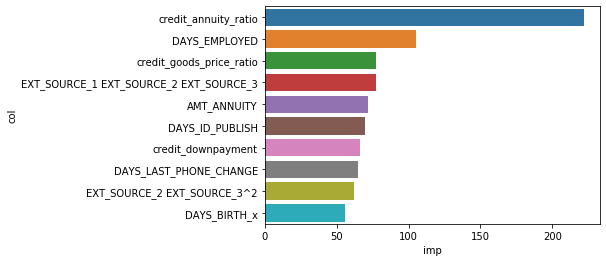

In [123]:
sns.barplot(x="imp", y="col", data=df3)

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
predict_fn_gbm = lambda x: gbmimp.predict_proba(x).astype(float)
X = X_train.values

explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = col,class_names=['Rembourse','Rembourse pas'],kernel_width=5)

In [ ]:
#123051
#df.drop(['TARGET_x', 'TARGET_y'], axis = 1).loc[[58246]]

In [103]:
gbmimp.predict_proba(df.drop(['SK_ID_CURR', 'TARGET_x', 'TARGET_y'], axis = 1).loc[[123051]])

array([[0.62642971, 0.37357029]])

In [126]:
X_test.loc[[200]]

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
200,-0.29842,-0.691779,0.668908,-0.59177,-0.102384,-0.16567,0.065657,0.0047,-0.373471,1.380985,...,-0.82359,-0.4401,0.366736,-0.87599,-0.572248,0.269113,1.467679,-0.338301,-1.041559,0.910744


In [ ]:
choosen_instance = X_test.loc[[200]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_gbm,num_features=10)
exp.show_in_notebook(show_all=False)

In [ ]:
choosen_instance = X_test.loc[[150]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_gbm,num_features=10)
exp.show_in_notebook(show_all=False)

In [ ]:
choosen_instance = X_test.loc[[5762]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_gbm,num_features=10)
exp.show_in_notebook(show_all=False)

In [ ]:
sub_sample = X_test[:10]

In [ ]:
sub_sample.to_csv('sub_sample.csv', index=False)

In [124]:
df3.to_csv('featureimp.csv', index=False)

In [ ]:
import streamlit as st

In [ ]:
st.title("Tableau de bord")
st.header(""" # Entrez un identifiant """)
iden = st.number_input('Entrez un identifiant')
st.write('L id du client est', iden)